In [56]:
import matplotlib
matplotlib.use('Agg')
from matplotlib import gridspec
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import matplotlib
import matplotlib.font_manager as font_manager
font_dirs = ['/mnt/e/Misc/Python_Fonts', ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)
matplotlib.rcParams['font.family'] = 'tahoma'

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
%matplotlib inline
from slmpy import ModularityOptimzer
import sklearn.cluster as cluster
import umap
from matplotlib.colors import Normalize
from matplotlib import cm
import matplotlib.patches as patches
import os
import copy
import scipy
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib import gridspec

In [20]:
# Load ensembl gene map
ensembl_gene_map={}
header = []
with open('/mnt/e/MPIMG/Rotation/elkabetz/AllenBrainAtlas/gencode.v10.annotation.gtf','r') as gencode_fn:
    for i,row in enumerate(gencode_fn):
        spl = row.strip("\n").split("\t")
        if row[0] == '#': continue
        elif len(header) == 0:
            header = spl
        else:
            split_info = spl[-1].split(";")
            for info in split_info:
                if 'gene_id' in info:
                    ensemble_id = info.split(" ")[1].split(".")[0].replace('"','')
                elif 'gene_name' in info:
                    gene_name = info.split(" ")[2].replace('"','')
            ensembl_gene_map[ensemble_id] = gene_name

In [21]:
huttner_dat = pd.read_csv('/mnt/e/MPIMG/Elkabetz/data/public_data/GSE38805_human_FPKM.txt',sep='\t')

gene_id = []
for ensembl_id in huttner_dat['ID']:
    if ensembl_id in ensembl_gene_map:
        gene_id.append(ensembl_gene_map[ensembl_id])
        pass
    else:
        gene_id.append('not found')
huttner_dat['gene'] = gene_id
huttner_dat = huttner_dat[huttner_dat['gene'] != 'not found']
huttner_dat = huttner_dat.drop(['ID'],axis=1)
huttner_dat.index = huttner_dat['gene']

huttner_dat_dict = huttner_dat.to_dict()

cp_samps = [x for x in huttner_dat.columns if 'CP' in x]
isvz_samps = [x for x in huttner_dat.columns if 'ISVZ' in x]
osvz_samps = [x for x in huttner_dat.columns if 'OSVZ' in x]
vz_samps = [x for x in huttner_dat.columns if '_VZ' in x]

avg_pd_dict = {}
genes = []
for gene in huttner_dat['gene']:
    if gene in genes:
        continue
    avg_pd_dict[gene] = []
    for samps in [cp_samps,isvz_samps,osvz_samps,vz_samps]:
        avg_pd_dict[gene].append(np.mean([huttner_dat_dict[x][gene] for x in samps if not np.isnan(huttner_dat_dict[x][gene])]))
    genes.append(gene)

huttner_avg_df = pd.DataFrame.from_dict(avg_pd_dict)
huttner_avg_df.columns = genes
huttner_avg_df.index = ['CP','ISVZ','OSVZ','VZ']
huttner_avg_df = huttner_avg_df.transpose()
huttner_avg_df = huttner_avg_df.fillna(0)

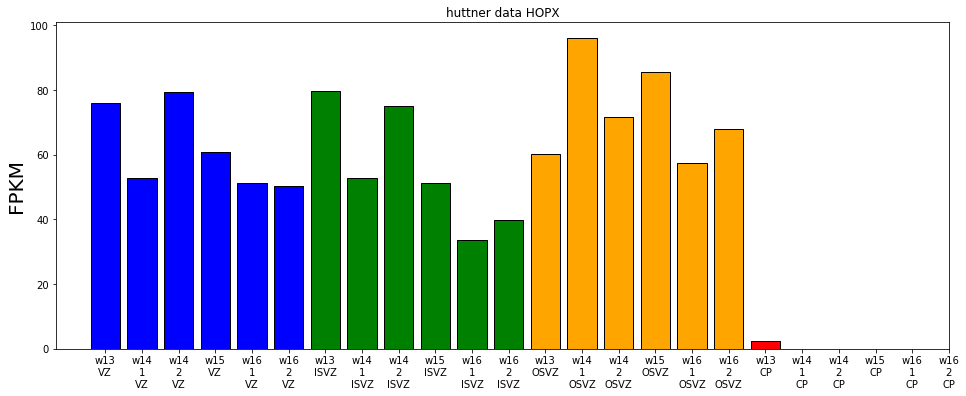

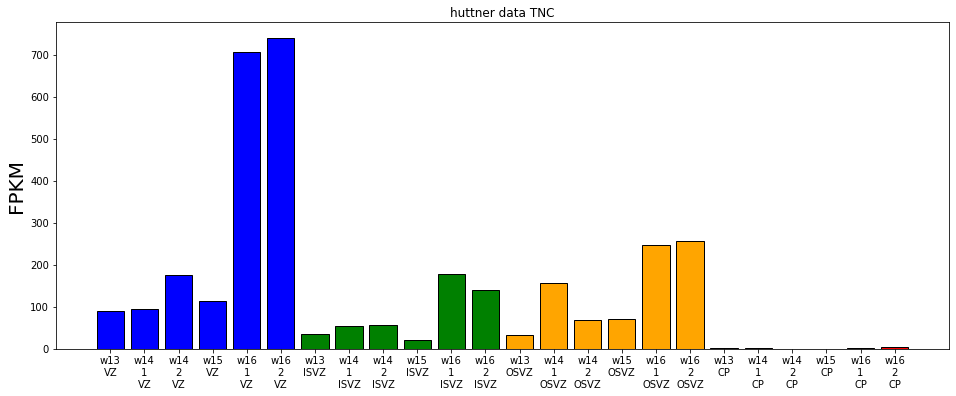

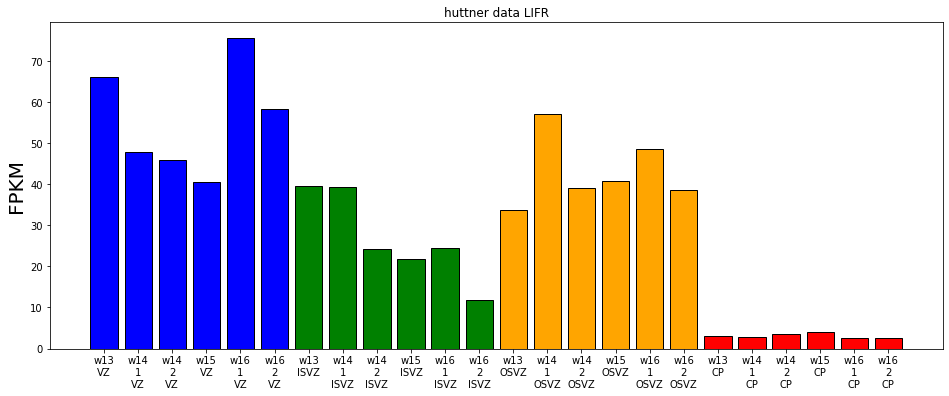

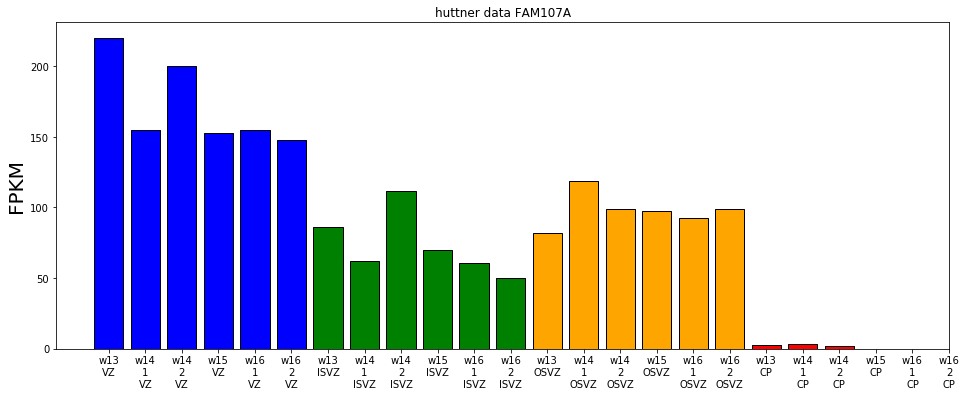

In [22]:
for gene in ['HOPX','TNC','LIFR','FAM107A']:
    plt.figure(figsize=(16,6))
    samps = []
    for type_ in ['_VZ','_ISVZ','_OSVZ','_CP']:
        samps.extend([x for x in huttner_dat.columns if type_ in x])
    color_dict = {}
    for samp in samps:
        if '_VZ' in samp: color_dict[samp] = 'blue'
        elif 'ISVZ' in samp: color_dict[samp] = 'green'
        elif 'OSVZ' in samp: color_dict[samp] = 'orange'
        else: color_dict[samp] = 'red'
    plt.bar(range(len(samps)),huttner_dat.loc[gene][samps],color=[color_dict[samp] for samp in samps],linewidth=1,edgecolor='black')
    plt.xticks(range(len(samps)),[x.replace('_','\n') for x in samps])
    plt.title('huttner data '+gene)
    plt.ylabel('FPKM',fontsize=20)
    plt.show()

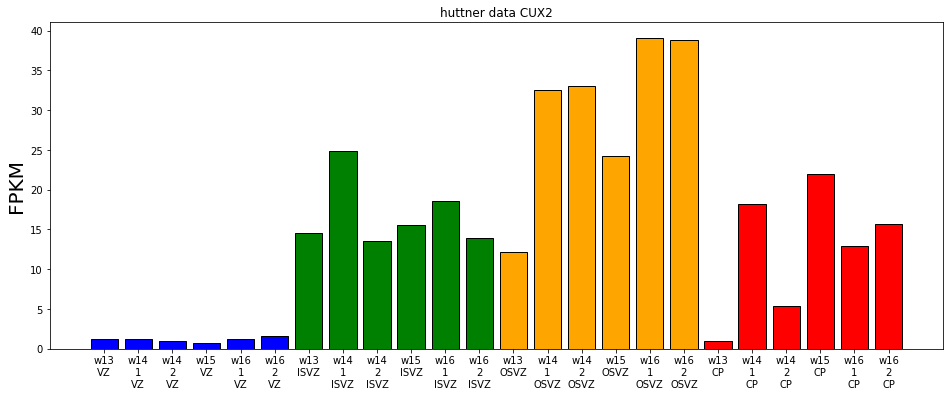

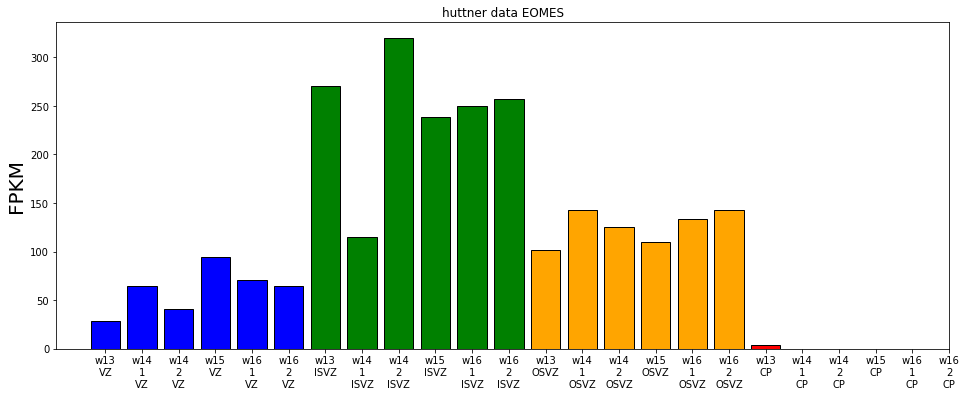

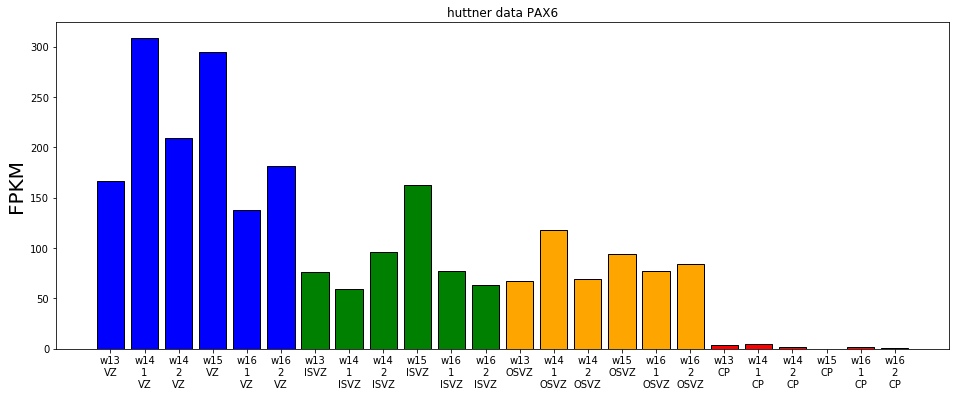

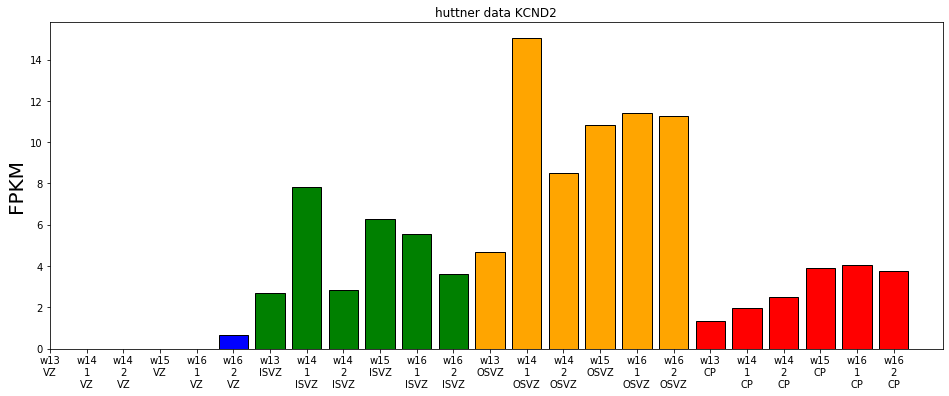

In [23]:
for gene in ['CUX2','EOMES','PAX6','KCND2']:
    plt.figure(figsize=(16,6))
    samps = []
    for type_ in ['_VZ','_ISVZ','_OSVZ','_CP']:
        samps.extend([x for x in huttner_dat.columns if type_ in x])
    color_dict = {}
    for samp in samps:
        if '_VZ' in samp: color_dict[samp] = 'blue'
        elif 'ISVZ' in samp: color_dict[samp] = 'green'
        elif 'OSVZ' in samp: color_dict[samp] = 'orange'
        else: color_dict[samp] = 'red'
    plt.bar(range(len(samps)),huttner_dat.loc[gene][samps],color=[color_dict[samp] for samp in samps],linewidth=1,edgecolor='black')
    plt.xticks(range(len(samps)),[x.replace('_','\n') for x in samps])
    plt.title('huttner data '+gene)
    plt.ylabel('FPKM',fontsize=20)
    plt.show()

In [24]:
xx = np.log(huttner_avg_df[['ISVZ','CP','VZ']]+1)/np.log(2)
xx = xx.max(axis=1)
yy = np.log(huttner_avg_df['OSVZ']+1)/np.log(2)
huttner_avg_df['OSVZ_enrich'] = yy-xx
xx = np.log(huttner_avg_df[['OSVZ','CP','VZ']]+1)/np.log(2)
xx = xx.max(axis=1)
yy = np.log(huttner_avg_df['ISVZ']+1)/np.log(2)
huttner_avg_df['ISVZ_enrich'] = yy-xx
sorted_osvz = huttner_avg_df.sort_values(['OSVZ_enrich'],ascending=False)[:1000]
sorted_osvz[sorted_osvz['CP'] + sorted_osvz['ISVZ'] + sorted_osvz['VZ'] > 0][50:100]

,CP,ISVZ,OSVZ,VZ,OSVZ_enrich,ISVZ_enrich
RHBDD1,3.768382,8.647723,16.690320,8.690523,0.868314,-0.874700
RP11-58B17.1,23.471925,33.837225,62.400875,16.878900,0.863873,-0.863873
VMA21,17.792800,17.795433,33.002533,16.897500,0.855260,-0.855260
CLEC16A,10.448783,10.605065,19.923417,7.529875,0.850364,-0.850364
NIPSNAP1,70.764640,77.348267,154.978133,85.619700,0.848577,-0.993371
KIAA1324L,7.892723,4.929782,15.007967,4.540618,0.848093,-1.432739
AC068580.6,0.003203,0.000000,0.803076,0.000000,0.845846,-0.850460
AGBL5,16.044033,18.763317,34.484650,17.918483,0.844370,-0.844370
RP3-426I6.2,5.545370,0.000000,10.640400,0.000000,0.830594,-3.541069
MSTO1,3.952024,0.679268,7.769840,1.201607,0.824532,-2.384718


In [25]:
## load in data

sc_dat_dir = '/mnt/e/MPIMG/Rotation/elkabetz/scrna/Brain/counts_elk/'
single_cell_data = {}
for fn in os.listdir(sc_dat_dir):
    print(fn)
    df = pd.read_csv(sc_dat_dir+fn,sep=',')
    df = df.set_index(df['Unnamed: 0'])
    df = df.drop('Unnamed: 0',axis=1)
    #mt_genes = [x for x in df.index if 'MT.' in x]
    #df = df.drop(mt_genes,axis=0)
    single_cell_data[fn.split(".")[0]] = df
    
single_cell_data_norm_rpm = {}
single_cell_data_norm_rpm_logged = {}
add_diff = 1.0
for clust in single_cell_data:

    sc_dat = single_cell_data[clust]
    cols = sc_dat
    sc_dat_backup = copy.deepcopy(sc_dat)
    sc_dat = copy.deepcopy(sc_dat_backup)
    
    ## gives you RPM
    sc_dat.loc[-1]  = sc_dat.sum()/10000.
    sc_dat = sc_dat.div(sc_dat.loc[-1],axis=1)
    sc_dat = sc_dat.drop([-1])
    single_cell_data_norm_rpm[clust] = sc_dat
    single_cell_data_norm_rpm_logged[clust] = np.log(sc_dat+1.)/np.log(2)
    
full_df_rpm_logged = {}
full_df_counts = {}
for clust in single_cell_data_norm_rpm_logged:
    if 'SBNG' in clust:
        if 'SBN' not in full_df_rpm_logged:
            full_df_rpm_logged['SBN'] = copy.deepcopy(single_cell_data_norm_rpm_logged[clust])
            full_df_counts['SBN'] = copy.deepcopy(single_cell_data[clust])
        else:
            full_df_rpm_logged['SBN'] = pd.concat([full_df_rpm_logged['SBN'],single_cell_data_norm_rpm_logged[clust]],axis=1)
            full_df_counts['SBN'] = pd.concat([full_df_counts['SBN'],single_cell_data[clust]],axis=1)
    if 'SBNx' in clust:
        if 'SBNx' not in full_df_rpm_logged:
            full_df_rpm_logged['SBNx'] = copy.deepcopy(single_cell_data_norm_rpm_logged[clust])
            full_df_counts['SBNx'] = copy.deepcopy(single_cell_data[clust])
        else:
            full_df_rpm_logged['SBNx'] = pd.concat([full_df_rpm_logged['SBNx'],single_cell_data_norm_rpm_logged[clust]],axis=1)
            full_df_counts['SBNx'] = pd.concat([full_df_counts['SBNx'],single_cell_data[clust]],axis=1)
    if 'NT' in clust:
        if 'NT' not in full_df_rpm_logged:
            full_df_rpm_logged['NT'] = copy.deepcopy(single_cell_data_norm_rpm_logged[clust])
            full_df_counts['NT'] = copy.deepcopy(single_cell_data[clust])
        else:
            full_df_rpm_logged['NT'] = pd.concat([full_df_rpm_logged['NT'],single_cell_data_norm_rpm_logged[clust]],axis=1)
            full_df_counts['NT'] = pd.concat([full_df_counts['NT'],single_cell_data[clust]],axis=1)
    if 'XG' in clust:
        if 'X' not in full_df_rpm_logged:
            full_df_rpm_logged['X'] = copy.deepcopy(single_cell_data_norm_rpm_logged[clust])
            full_df_counts['X'] = copy.deepcopy(single_cell_data[clust])
        else:
            full_df_rpm_logged['X'] = pd.concat([full_df_rpm_logged['X'],single_cell_data_norm_rpm_logged[clust]],axis=1)
            full_df_counts['X'] = pd.concat([full_df_counts['X'],single_cell_data[clust]],axis=1)
            
for i,tx in enumerate(full_df_counts.keys()):
    tmp_df=copy.deepcopy(full_df_counts[tx])
    tmp_df[-1] = tmp_df.sum(axis=1)
    tmp_df=tmp_df.drop([x for x in tmp_df.columns if x != -1],axis=1)
    tmp_df=tmp_df.rename(index=str, columns={-1: tx})
    if i == 0:
        merged_counts_df = copy.deepcopy(tmp_df)
    else:
        merged_counts_df = pd.concat([merged_counts_df,tmp_df],axis=1)

merged_counts_df = merged_counts_df.fillna(0)
sc_dat = copy.deepcopy(merged_counts_df)
sc_dat.loc[-1]  = sc_dat.sum()/10000.
sc_dat = sc_dat.div(sc_dat.loc[-1],axis=1)
sc_dat = sc_dat.drop([-1])
merged_counts_df_rpm_logged = np.log(sc_dat+1.)/np.log(2)

for i,tx in enumerate(full_df_rpm_logged.keys()):
    tmp_df=copy.deepcopy(full_df_rpm_logged[tx])
    tmp_df[-1] = tmp_df.mean(axis=1)
    tmp_df=tmp_df.drop([x for x in tmp_df.columns if x != -1],axis=1)
    tmp_df=tmp_df.rename(index=str, columns={-1: tx})
    if i == 0:
        avg_logged_rpm_df = copy.deepcopy(tmp_df)
    else:
        avg_logged_rpm_df = pd.concat([avg_logged_rpm_df,tmp_df],axis=1)
avg_logged_rpm_df = avg_logged_rpm_df.fillna(0)

full_df_counts['X'].columns = ['x.'+col for col in full_df_counts['X'].columns]
full_df_counts['NT'].columns = ['nt.'+col for col in full_df_counts['NT'].columns]
full_df_counts['SBN'].columns = ['sbn.'+col for col in full_df_counts['SBN'].columns]
full_df_counts['SBNx'].columns = ['sbnx.'+col for col in full_df_counts['SBNx'].columns]

NTG1.csv
NTG2.csv
NTG3.csv
NTG4.csv
NTG5.csv
NTG6.csv
NTG7.csv
NTG8.csv
NTG9.csv
SBNG1.csv
SBNG10.csv
SBNG11.csv
SBNG2.csv
SBNG3.csv
SBNG4.csv
SBNG5.csv
SBNG6.csv
SBNG7.csv
SBNG8.csv
SBNG9.csv
SBNxG1.csv
SBNxG10.csv
SBNxG2.csv
SBNxG3.csv
SBNxG4.csv
SBNxG5.csv
SBNxG6.csv
SBNxG7.csv
SBNxG8.csv
SBNxG9.csv
XG1.csv
XG2.csv
XG3.csv
XG4.csv
XG5.csv
XG6.csv
XG7.csv
XG8.csv
XG9.csv


/home/rose/.local/lib/python3.6/site-packages/ipykernel_launcher.py:71: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

/home/rose/.local/lib/python3.6/site-packages/ipykernel_launcher.py:88: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [26]:
df = pd.read_csv('/mnt/e/MPIMG/Elkabetz/notebooks/Seurat_runs/merged_sbnx_sbn_nt_all_runs/dims6_res0.6/metadata.sbnx_sbn_nt.csv',sep=',')
df_sbnx_sbn_clust = copy.deepcopy(df)

df = pd.read_csv('/mnt/e/MPIMG/Elkabetz/notebooks/Seurat_runs/merged_sbnx_sbn_nt_all_runs/dims6_res0.6/tsne.sbnx_sbn_nt.csv',sep=',')
df.columns=['cell','tSNE_1','tSNE_2']
df_sbnx_sbn_tsne = copy.deepcopy(df)

df = pd.read_csv('/mnt/e/MPIMG/Elkabetz/notebooks/Seurat_runs/merged_sbnx_sbn_nt_all_runs/dims6_res0.6/pca.sbnx_sbn_nt.csv',sep=',')
cols = list(df.columns)
cols[0] = 'cell'
df.columns = cols
df_sbnx_sbn_pca = copy.deepcopy(df)

df = pd.read_csv('/mnt/e/MPIMG/Elkabetz/notebooks/Seurat_runs/merged_sbnx_sbn_nt_all_runs/dims6_res0.6/markers.sbnx_sbn_nt.csv',sep=',')
df_markers = copy.deepcopy(df)

df = pd.read_csv('/mnt/e/MPIMG/Elkabetz/notebooks/Seurat_runs/merged_sbnx_sbn_nt_all_runs/dims6_res0.6/markers.all.sbnx_sbn_nt.csv',sep=',')
df_markers_all = copy.deepcopy(df)

In [27]:
all_genes = set([])
clust_df_counts = {}
for clust in set(df_sbnx_sbn_clust['res.0.6']):
    cells_in_clust = list(df_sbnx_sbn_clust['Unnamed: 0'][df_sbnx_sbn_clust['res.0.6'] == clust])
    print(clust,len(cells_in_clust))
    for j,tx in enumerate(['SBNx','SBN','NT']):
        cells_in_clust_in_tx = [x for x in cells_in_clust if x.split(".")[0] == tx.lower()]
        if clust not in clust_df_counts:
            if len(cells_in_clust_in_tx) > 0:
                clust_df_counts[clust] = copy.deepcopy(full_df_counts[tx][cells_in_clust_in_tx])
        else:
            if len(cells_in_clust_in_tx) > 0:
                clust_df_counts[clust] = pd.concat([clust_df_counts[clust],full_df_counts[tx][cells_in_clust_in_tx]],axis=1)

for clust in clust_df_counts:
    clust_df_counts[clust] = clust_df_counts[clust].fillna(0)
    all_genes = set(all_genes.union(set(clust_df_counts[clust].index)))

clust_df_log_rpm = {}
for clust in clust_df_counts:
    clust_df_log_rpm[clust] = copy.deepcopy(clust_df_counts[clust])
    tot_sum = clust_df_log_rpm[clust].sum()/10000.
    clust_df_log_rpm[clust] = clust_df_log_rpm[clust].div(tot_sum)
    clust_df_log_rpm[clust] = np.log(clust_df_log_rpm[clust]+1)/np.log(2)

0 1351


/home/rose/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  del sys.path[0]


1 1221
2 1052
3 1028
4 959
5 951
6 610
7 540
8 407
9 366
10 285
11 208


In [28]:
summed_counts_per_clust = {}
for clust in clust_df_counts:
    summed_counts_per_clust[clust] = clust_df_counts[clust].sum(axis=1)
    tot_sum = summed_counts_per_clust[clust].sum()/10000.
    summed_counts_per_clust[clust] = summed_counts_per_clust[clust].div(tot_sum)
    summed_counts_per_clust[clust] = np.log(summed_counts_per_clust[clust]+1.)/np.log(2)

In [29]:
huttner_avg_df_logged = np.log(huttner_avg_df+1)/np.log(2)
huttner_avg_df_logged = huttner_avg_df_logged.fillna(0)
huttner_avg_df_logged

/home/rose/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


,CP,ISVZ,OSVZ,VZ,OSVZ_enrich,ISVZ_enrich
TSPAN6,3.556516,5.619924,5.409858,6.281890,-2.966151,-1.564762
DPM1,4.070696,4.793814,4.603103,4.878639,-0.465013,-0.127881
SCYL3,2.183323,1.950100,1.862154,2.868196,0.000000,-3.609928
C1orf112,1.645921,1.744488,1.885979,2.523618,-1.464500,-2.178728
CFH,0.000000,0.000000,0.936451,0.907648,0.040967,-3.975978
...,...,...,...,...,...,...
GRINL1A,2.577001,2.969745,0.923885,2.437852,0.000000,0.477930
RP11-313I2.5,0.000000,0.000000,0.000000,0.976006,-5.381168,-5.381168
RP11-627G23.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
RP11-49M9.2,2.187226,0.000000,2.428405,2.692859,-0.443112,0.000000


In [30]:
cortical_clusts = [1,7,5,3,0]
cols_to_add = []
for clust in cortical_clusts:
    cols_to_add.append([])
for gene in huttner_avg_df_logged.index:
    for j,clust in enumerate(cortical_clusts):
        if gene in summed_counts_per_clust[clust]:
            cols_to_add[j].append(summed_counts_per_clust[clust][gene])
        else:
            cols_to_add[j].append(0)
            
labs = ['Radial Glia','Cycling Radial Glia','Transitory State','Intermediate Progenitors','Neurons']
for j,clust in enumerate(cortical_clusts):
    huttner_avg_df_logged[labs[j]] = cols_to_add[j]

In [31]:
marker_genes = list(set(df_markers_all[df_markers_all['cluster'].isin([1,5,3,0])]['Unnamed: 0']))
shared_marker_genes = list(set(huttner_avg_df_logged.index).intersection(set(marker_genes)))
huttner_avg_df_logged_marker_genes = huttner_avg_df_logged.loc[shared_marker_genes]

In [32]:
### try mapping each cell in each clust to a region
huttner_avg_df_logged = np.log(huttner_avg_df+1)/np.log(2)
huttner_avg_df_logged = huttner_avg_df_logged.fillna(0)
huttner_avg_df_logged

cortical_clusts = [1,7,5,3,0]

cols_to_add = []
for j,clust in enumerate(cortical_clusts):
    print(clust)
    ordered_clust_df = clust_df_log_rpm[clust][[cell for cell in clust_df_log_rpm[clust].columns]].loc[huttner_avg_df_logged.index]
    huttner_avg_df_logged = pd.concat([huttner_avg_df_logged,ordered_clust_df],axis=1)

/home/rose/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  
/home/rose/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  # This is added back by InteractiveShellApp.init_path()


1
7
5
3
0


In [33]:
shared_marker_genes = list(set(huttner_avg_df_logged.index).intersection(set(marker_genes)))
huttner_avg_df_logged_marker_genes = huttner_avg_df_logged.loc[shared_marker_genes]
huttner_avg_df_logged_marker_genes = huttner_avg_df_logged_marker_genes.fillna(0)
huttner_avg_df_logged = huttner_avg_df_logged.fillna(0)

In [34]:
cells_to_add = []
for clust in cortical_clusts:
    cells_to_add.extend(list(clust_df_log_rpm[clust].columns))

In [35]:
corr_maps_tx = {}
corr_map = {}
corr_map_full = {}
for huttner_samp in ['VZ','ISVZ','OSVZ','CP']:
    for org_cell in cells_to_add:
        #if 'sbnx.' not in org_cell: continue
        x,y = huttner_avg_df_logged_marker_genes[huttner_samp],huttner_avg_df_logged_marker_genes[org_cell]
        corr_map_full[(huttner_samp,org_cell)] =  np.corrcoef(x,y)[0][1]

for tx in ['sbnx','sbn','nt']:
    corr_map = {}
    for huttner_samp in ['VZ','ISVZ','OSVZ','CP']:
        for org_cell in cells_to_add:
            if tx+'.' not in org_cell: continue
            x,y = huttner_avg_df_logged_marker_genes[huttner_samp],huttner_avg_df_logged_marker_genes[org_cell]
            corr_map[(huttner_samp,org_cell)] =  np.corrcoef(x,y)[0][1]
    corr_maps_tx[tx] = corr_map
        
#corr_map_full = {}
#for huttner_samp in ['VZ','ISVZ','OSVZ','CP']:
#    for org_clust in labs:
#        x,y = huttner_avg_df_logged[huttner_samp],huttner_avg_df_logged[org_clust]
#        corr_map_full[(huttner_samp,org_clust)] =  np.corrcoef(x,y)[0][1]

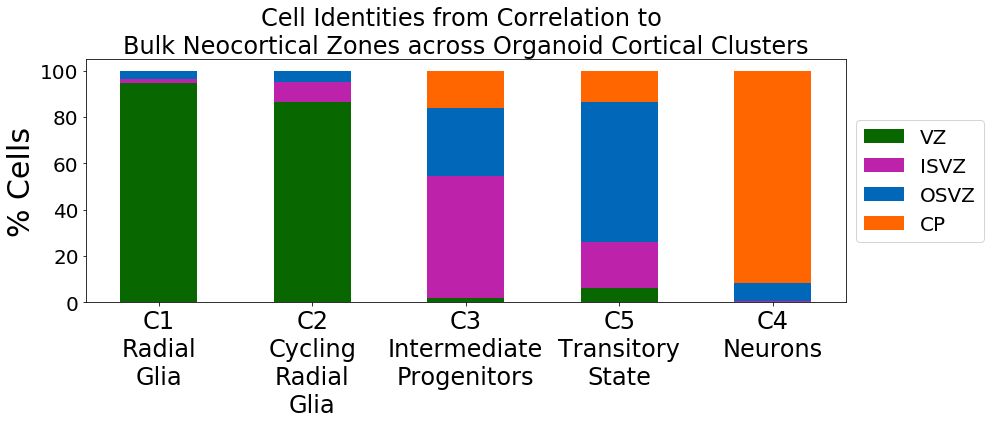

In [36]:
hutt_samps = ['VZ','ISVZ','OSVZ','CP']
hutt_samp_dict = {'VZ':'blue','ISVZ':'green','OSVZ':'orange','CP':'red'}
cortical_map = {1:'Radial Glia',7:'Cycling Radial Glia',5:'Transitory State',3:'Intermediate Progenitors',0:'Neurons'}
cort_clusts = [(1,'Radial Glia'),(7,'Cycling Radial Glia'),(3,'Intermediate Progenitors'),(5,'Transitory State'),(0,'Neurons')]
clust_out_map={1:1,7:2,5:5,3:3,0:4}
plt.figure(figsize=(12,6))
ax=plt.subplot(111)
colorss=['blue','green','orange','red','gray']
colorss=[(255./255.,204./255,0),(255./255.,153./255,0),(255./255.,102./255,0),(153./255.,51./255,0)]
colorss=[(9./255.,103./255,0),(189./255.,34./255,170/255.),(1./255.,104./255,185./255),(255./255.,102./255,0)]

for k,clust in enumerate([1,7,3,5,0]):
    
    #ax = plt.subplot(int(str('51')+str(k+1)))
    corrs = {}
    for huttner_samp in hutt_samps:
        corrs[huttner_samp] = []
        for cell in clust_df_log_rpm[clust].columns:
            if (huttner_samp,cell) not in corr_map_full: continue
            corrs[huttner_samp].append(corr_map_full[(huttner_samp,cell)])
    
    num_assign = {}
    for huttner_samp in hutt_samps:
        num_assign[huttner_samp] = 0
    #num_assign['unknown'] = 0
    
    for j in range(len(corrs['VZ'])):
        corr_list = [corrs[huttner_samp][j] for huttner_samp in hutt_samps]
        #if sorted(corr_list)[-1]/sorted(corr_list)[-2] < 1.05:
        #    num_assign['unknown'] += 1
        #else:
        num_assign[hutt_samps[np.argmax(corr_list)]] += 1

    #plt.bar(range(len(num_assign)),[num_assign[x] for x in num_assign],color=['blue','green','orange','red','gray'],linewidth=1,edgecolor='black')
    prev_y = 0
    sum_assign = float(sum(num_assign.values()))
    for j,x in enumerate(num_assign):
        if k == 4:
            plt.bar(k,num_assign[x]/sum_assign,bottom=prev_y,color=colorss[j],width=0.5,label=hutt_samps[j])
        else:
            plt.bar(k,num_assign[x]/sum_assign,bottom=prev_y,color=colorss[j],width=0.5)#,linewidth=1,edgecolor='black')
        prev_y += num_assign[x]/sum_assign
    

plt.xticks(range(len([1,7,3,5,0])),['C'+str(clust_out_map[x[0]])+'\n'+x[1].replace(' ','\n').replace('-','-\n') \
                                           for x in cort_clusts],fontsize=24)
plt.ylim(0,1.05)
plt.title('Cell Identities from Correlation to \nBulk Neocortical Zones across Organoid Cortical Clusters',fontsize=24)
plt.ylabel('% Cells',fontsize=30)
plt.yticks([0,0.2,0.4,0.6,0.8,1],[0,20,40,60,80,100],fontsize=20)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
lgd = ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),fontsize=20)

plt.tight_layout()
plt.savefig('/mnt/e/MPIMG/Elkabetz/Mutukula_etal_Paper/Supplemental_Figures/Fig1/huttner_corr_1c_a.pdf',
            bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

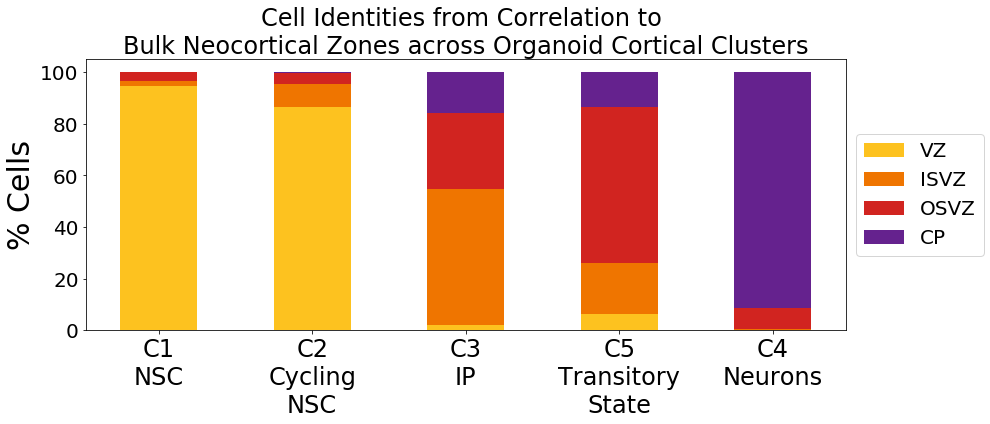

In [37]:
hutt_samps = ['VZ','ISVZ','OSVZ','CP']
hutt_samp_dict = {'VZ':'yellow','ISVZ':'orange','OSVZ':'red','CP':'purple'}
cortical_map = {1:'Radial Glia',7:'Cycling Radial Glia',5:'Transitory State',3:'Intermediate Progenitors',0:'Neurons'}
cort_clusts = [(1,'NSC'),(7,'Cycling NSC'),(3,'IP'),(5,'Transitory State'),(0,'Neurons')]
clust_out_map={1:1,7:2,5:5,3:3,0:4}
plt.figure(figsize=(12,6))
ax=plt.subplot(111)
colorss=['gold','orange','red','purple','gray']
colorss=[(253./255.,194./255,31./255),(239./255.,117./255,0./255),(209./255.,36./255,32./255),(101./255.,34./255,142./255)]
#colorss=[(255./255.,204./255,0),(255./255.,153./255,0),(255./255.,102./255,0),(153./255.,51./255,0)]
#colorss=[(9./255.,103./255,0),(189./255.,34./255,170/255.),(1./255.,104./255,185./255),(255./255.,102./255,0)]

for k,clust in enumerate([1,7,3,5,0]):
    
    #ax = plt.subplot(int(str('51')+str(k+1)))
    corrs = {}
    for huttner_samp in hutt_samps:
        corrs[huttner_samp] = []
        for cell in clust_df_log_rpm[clust].columns:
            if (huttner_samp,cell) not in corr_map_full: continue
            corrs[huttner_samp].append(corr_map_full[(huttner_samp,cell)])
    
    num_assign = {}
    for huttner_samp in hutt_samps:
        num_assign[huttner_samp] = 0
    #num_assign['unknown'] = 0
    
    for j in range(len(corrs['VZ'])):
        corr_list = [corrs[huttner_samp][j] for huttner_samp in hutt_samps]
        #if sorted(corr_list)[-1]/sorted(corr_list)[-2] < 1.05:
        #    num_assign['unknown'] += 1
        #else:
        num_assign[hutt_samps[np.argmax(corr_list)]] += 1

    #plt.bar(range(len(num_assign)),[num_assign[x] for x in num_assign],color=['blue','green','orange','red','gray'],linewidth=1,edgecolor='black')
    prev_y = 0
    sum_assign = float(sum(num_assign.values()))
    for j,x in enumerate(num_assign):
        if k == 4:
            plt.bar(k,num_assign[x]/sum_assign,bottom=prev_y,color=colorss[j],width=0.5,label=hutt_samps[j])
        else:
            plt.bar(k,num_assign[x]/sum_assign,bottom=prev_y,color=colorss[j],width=0.5)#,linewidth=1,edgecolor='black')
        prev_y += num_assign[x]/sum_assign
    

plt.xticks(range(len([1,7,3,5,0])),['C'+str(clust_out_map[x[0]])+'\n'+x[1].replace(' ','\n').replace('-','-\n') \
                                           for x in cort_clusts],fontsize=24)
plt.ylim(0,1.05)
plt.title('Cell Identities from Correlation to \nBulk Neocortical Zones across Organoid Cortical Clusters',fontsize=24)
plt.ylabel('% Cells',fontsize=30)
plt.yticks([0,0.2,0.4,0.6,0.8,1],[0,20,40,60,80,100],fontsize=20)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
lgd = ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),fontsize=20)

plt.tight_layout()
plt.savefig('/mnt/e/MPIMG/Elkabetz/Mutukula_etal_Paper/Figures/huttner_corr_1c_a.pdf',
            bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

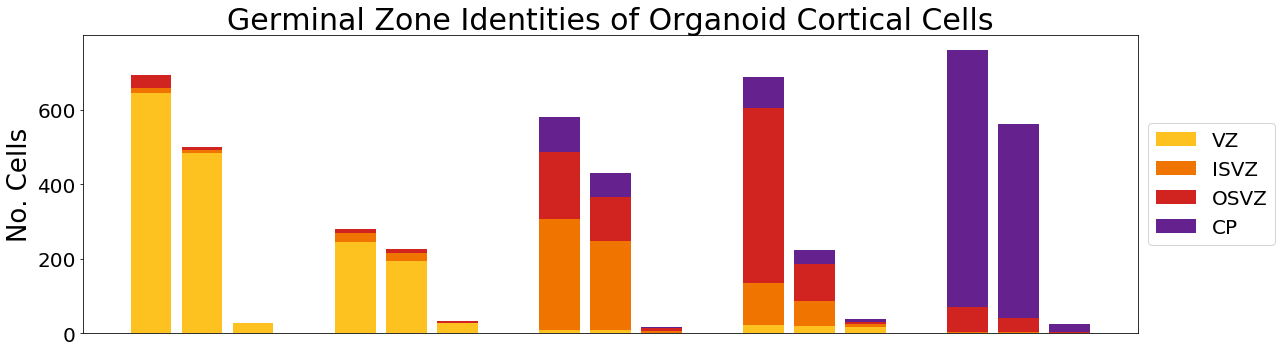

In [48]:
hutt_samps = ['VZ','ISVZ','OSVZ','CP']
hutt_samp_dict = {'VZ':'yellow','ISVZ':'orange','OSVZ':'red','CP':'purple'}
cortical_map = {1:'Radial Glia',7:'Cycling Radial Glia',5:'Transitory State',3:'Intermediate Progenitors',0:'Neurons'}
colorss=['gold','orange','red','purple','gray']
colorss=[(253./255.,194./255,31./255),(239./255.,117./255,0./255),(209./255.,36./255,32./255),(101./255.,34./255,142./255)]

plt.figure(figsize=(16,5))
ax=plt.subplot(111)

for jj,tx in enumerate(['sbnx','sbn','nt']):
    
    for k,clust in enumerate([1,7,3,5,0]):

        #ax = plt.subplot(int(str('51')+str(k+1)))
        corrs = {}
        for huttner_samp in hutt_samps:
            corrs[huttner_samp] = []
            for cell in clust_df_log_rpm[clust].columns:
                if (huttner_samp,cell) not in corr_maps_tx[tx]: continue
                corrs[huttner_samp].append(corr_maps_tx[tx][(huttner_samp,cell)])

        num_assign = {}
        for huttner_samp in hutt_samps:
            num_assign[huttner_samp] = 0
        #num_assign['unknown'] = 0

        for j in range(len(corrs['VZ'])):
            corr_list = [corrs[huttner_samp][j] for huttner_samp in hutt_samps]
            #if sorted(corr_list)[-1]/sorted(corr_list)[-2] < 1.05:
            #    num_assign['unknown'] += 1
            #else:
            num_assign[hutt_samps[np.argmax(corr_list)]] += 1

        #plt.bar(range(len(num_assign)),[num_assign[x] for x in num_assign],color=['blue','green','orange','red','gray'],linewidth=1,edgecolor='black')
        prev_y = 0
        sum_assign = float(sum(num_assign.values()))
        for j,x in enumerate(num_assign):
            if k==4 and tx == 'sbnx':
                #plt.bar(4*k+jj,num_assign[x]/sum_assign,bottom=prev_y,color=colorss[j],label=hutt_samps[j])#,linewidth=1,edgecolor='black')
                plt.bar(4*k+jj,num_assign[x],bottom=prev_y,color=colorss[j],label=hutt_samps[j])#,linewidth=1,edgecolor='black')
            else:
                #plt.bar(4*k+jj,num_assign[x]/sum_assign,bottom=prev_y,color=colorss[j])
                plt.bar(4*k+jj,num_assign[x],bottom=prev_y,color=colorss[j])
            #prev_y += num_assign[x]/sum_assign
            prev_y += num_assign[x]
    
xtick_labs = []
for x in cort_clusts:
    xtick_labs.append('sbnx')
    xtick_labs.append('sbn\n'+'C'+str(clust_out_map[x[0]])+'\n'+x[1])#.replace(' ','\n').replace('-','-\n'))
    #xtick_labs.append('sbn\n'+x[1])#.replace(' ','\n').replace('-','-\n'))
    xtick_labs.append('nt')
    xtick_labs.append('')
    #xtick_labs.append('')
    #xtick_labs.append('C'+str(clust_out_map[x[0]])+'\n'+x[1].replace(' ','\n').replace('-','-\n'))
    #xtick_labs.append('')
    #xtick_labs.append('')
    
plt.xticks(range(len([1,7,3,5,0])*4),xtick_labs,fontsize=22)
plt.xticks([])
#plt.ylim(0,1.05)
plt.title('Germinal Zone Identities of Organoid Cortical Cells',fontsize=30)
plt.ylabel('No. Cells',fontsize=26)
plt.yticks([0,200,400,600],[0,200,400,600],fontsize=20)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
lgd=ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=20)
plt.tight_layout()
plt.savefig('/mnt/e/MPIMG/Elkabetz/Mutukula_etal_Paper/Figures/huttner_corr_1c_a.pdf',
            bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

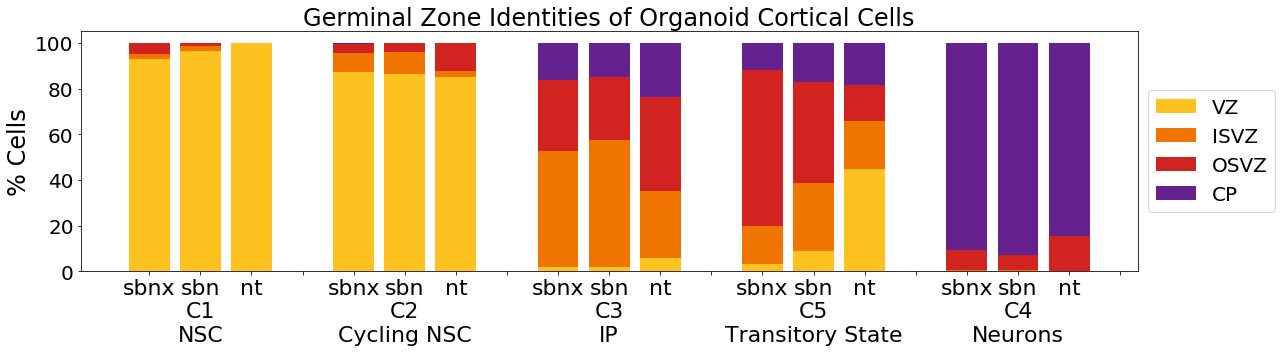

In [45]:
hutt_samps = ['VZ','ISVZ','OSVZ','CP']
hutt_samp_dict = {'VZ':'yellow','ISVZ':'orange','OSVZ':'red','CP':'purple'}
cortical_map = {1:'Radial Glia',7:'Cycling Radial Glia',5:'Transitory State',3:'Intermediate Progenitors',0:'Neurons'}
colorss=['gold','orange','red','purple','gray']
colorss=[(253./255.,194./255,31./255),(239./255.,117./255,0./255),(209./255.,36./255,32./255),(101./255.,34./255,142./255)]

plt.figure(figsize=(16,5))
ax=plt.subplot(111)

for jj,tx in enumerate(['sbnx','sbn','nt']):
    
    for k,clust in enumerate([1,7,3,5,0]):

        #ax = plt.subplot(int(str('51')+str(k+1)))
        corrs = {}
        for huttner_samp in hutt_samps:
            corrs[huttner_samp] = []
            for cell in clust_df_log_rpm[clust].columns:
                if (huttner_samp,cell) not in corr_maps_tx[tx]: continue
                corrs[huttner_samp].append(corr_maps_tx[tx][(huttner_samp,cell)])

        num_assign = {}
        for huttner_samp in hutt_samps:
            num_assign[huttner_samp] = 0
        #num_assign['unknown'] = 0

        for j in range(len(corrs['VZ'])):
            corr_list = [corrs[huttner_samp][j] for huttner_samp in hutt_samps]
            #if sorted(corr_list)[-1]/sorted(corr_list)[-2] < 1.05:
            #    num_assign['unknown'] += 1
            #else:
            num_assign[hutt_samps[np.argmax(corr_list)]] += 1

        #plt.bar(range(len(num_assign)),[num_assign[x] for x in num_assign],color=['blue','green','orange','red','gray'],linewidth=1,edgecolor='black')
        prev_y = 0
        sum_assign = float(sum(num_assign.values()))
        for j,x in enumerate(num_assign):
            if k==4 and tx == 'sbnx':
                plt.bar(4*k+jj,num_assign[x]/sum_assign,bottom=prev_y,color=colorss[j],label=hutt_samps[j])#,linewidth=1,edgecolor='black')
                #plt.bar(4*k+jj,num_assign[x],bottom=prev_y,color=colorss[j],label=hutt_samps[j])#,linewidth=1,edgecolor='black')
            else:
                plt.bar(4*k+jj,num_assign[x]/sum_assign,bottom=prev_y,color=colorss[j])
                #plt.bar(4*k+jj,num_assign[x],bottom=prev_y,color=colorss[j])
            prev_y += num_assign[x]/sum_assign
            #prev_y += num_assign[x]
    
xtick_labs = []
for x in cort_clusts:
    xtick_labs.append('sbnx')
    xtick_labs.append('sbn\n'+'C'+str(clust_out_map[x[0]])+'\n'+x[1])#.replace(' ','\n').replace('-','-\n'))
    xtick_labs.append('nt')
    xtick_labs.append('')
    #xtick_labs.append('')
    #xtick_labs.append('C'+str(clust_out_map[x[0]])+'\n'+x[1].replace(' ','\n').replace('-','-\n'))
    #xtick_labs.append('')
    #xtick_labs.append('')
    
plt.xticks(range(len([1,7,3,5,0])*4),xtick_labs,fontsize=22)
plt.ylim(0,1.05)
#plt.title('Germinal Zone Identities of Organoid Cortical Cells',fontsize=24)
plt.ylabel('% Cells',fontsize=24)
plt.yticks([0,0.2,0.4,0.6,0.8,1],[0,20,40,60,80,100],fontsize=20)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
lgd=ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=20)
plt.tight_layout()
plt.savefig('/mnt/e/MPIMG/Elkabetz/Mutukula_etal_Paper/Figures/huttner_corr_1c_b.pdf',
            bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

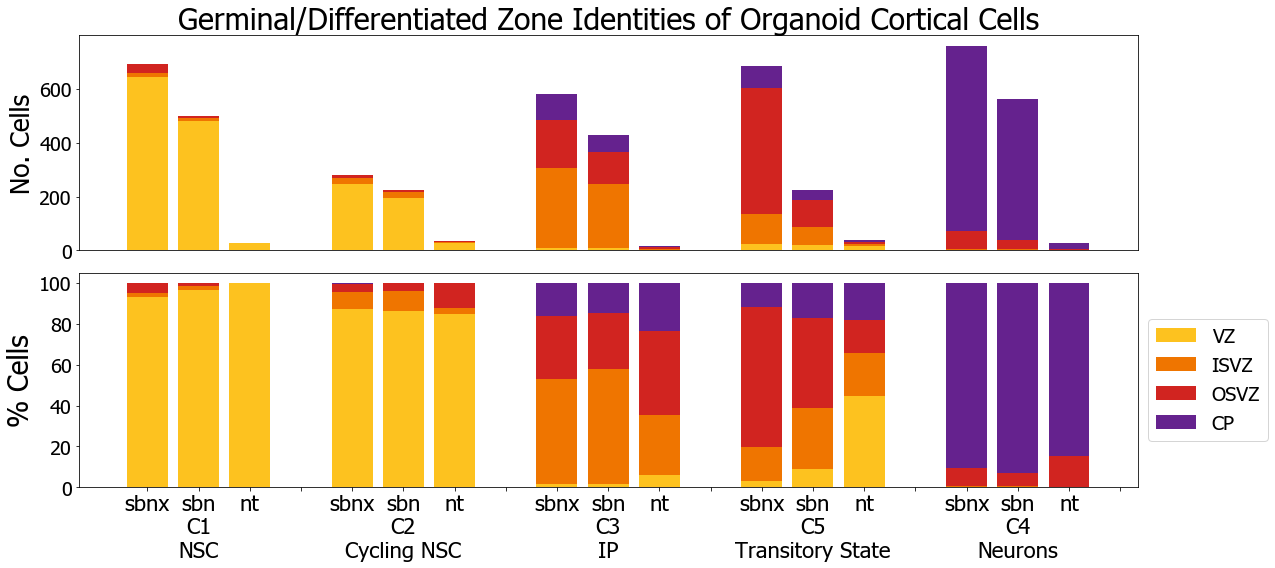

In [58]:
hutt_samps = ['VZ','ISVZ','OSVZ','CP']
hutt_samp_dict = {'VZ':'yellow','ISVZ':'orange','OSVZ':'red','CP':'purple'}
cortical_map = {1:'Radial Glia',7:'Cycling Radial Glia',5:'Transitory State',3:'Intermediate Progenitors',0:'Neurons'}
colorss=['gold','orange','red','purple','gray']
colorss=[(253./255.,194./255,31./255),(239./255.,117./255,0./255),(209./255.,36./255,32./255),(101./255.,34./255,142./255)]

plt.figure(figsize=(16,8))
ax=plt.subplot(211)

for jj,tx in enumerate(['sbnx','sbn','nt']):
    
    for k,clust in enumerate([1,7,3,5,0]):

        #ax = plt.subplot(int(str('51')+str(k+1)))
        corrs = {}
        for huttner_samp in hutt_samps:
            corrs[huttner_samp] = []
            for cell in clust_df_log_rpm[clust].columns:
                if (huttner_samp,cell) not in corr_maps_tx[tx]: continue
                corrs[huttner_samp].append(corr_maps_tx[tx][(huttner_samp,cell)])

        num_assign = {}
        for huttner_samp in hutt_samps:
            num_assign[huttner_samp] = 0
        #num_assign['unknown'] = 0

        for j in range(len(corrs['VZ'])):
            corr_list = [corrs[huttner_samp][j] for huttner_samp in hutt_samps]
            #if sorted(corr_list)[-1]/sorted(corr_list)[-2] < 1.05:
            #    num_assign['unknown'] += 1
            #else:
            num_assign[hutt_samps[np.argmax(corr_list)]] += 1

        #plt.bar(range(len(num_assign)),[num_assign[x] for x in num_assign],color=['blue','green','orange','red','gray'],linewidth=1,edgecolor='black')
        prev_y = 0
        sum_assign = float(sum(num_assign.values()))
        for j,x in enumerate(num_assign):
            if k==4 and tx == 'sbnx':
                #plt.bar(4*k+jj,num_assign[x]/sum_assign,bottom=prev_y,color=colorss[j],label=hutt_samps[j])#,linewidth=1,edgecolor='black')
                plt.bar(4*k+jj,num_assign[x],bottom=prev_y,color=colorss[j],label=hutt_samps[j])#,linewidth=1,edgecolor='black')
            else:
                #plt.bar(4*k+jj,num_assign[x]/sum_assign,bottom=prev_y,color=colorss[j])
                plt.bar(4*k+jj,num_assign[x],bottom=prev_y,color=colorss[j])
            #prev_y += num_assign[x]/sum_assign
            prev_y += num_assign[x]
    
xtick_labs = []
for x in cort_clusts:
    xtick_labs.append('sbnx')
    xtick_labs.append('sbn\n'+'C'+str(clust_out_map[x[0]])+'\n'+x[1])#.replace(' ','\n').replace('-','-\n'))
    #xtick_labs.append('sbn\n'+x[1])#.replace(' ','\n').replace('-','-\n'))
    xtick_labs.append('nt')
    xtick_labs.append('')
    #xtick_labs.append('')
    #xtick_labs.append('C'+str(clust_out_map[x[0]])+'\n'+x[1].replace(' ','\n').replace('-','-\n'))
    #xtick_labs.append('')
    #xtick_labs.append('')
    
plt.xticks(range(len([1,7,3,5,0])*4),xtick_labs,fontsize=22)
plt.xticks([])
#plt.ylim(0,1.05)
plt.title('Germinal/Differentiated Zone Identities of Organoid Cortical Cells',fontsize=30)
plt.ylabel('No. Cells',fontsize=26)
plt.yticks([0,200,400,600],[0,200,400,600],fontsize=20)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
#lgd=ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=20)
plt.tight_layout()


hutt_samps = ['VZ','ISVZ','OSVZ','CP']
hutt_samp_dict = {'VZ':'yellow','ISVZ':'orange','OSVZ':'red','CP':'purple'}
cortical_map = {1:'Radial Glia',7:'Cycling Radial Glia',5:'Transitory State',3:'Intermediate Progenitors',0:'Neurons'}
colorss=['gold','orange','red','purple','gray']
colorss=[(253./255.,194./255,31./255),(239./255.,117./255,0./255),(209./255.,36./255,32./255),(101./255.,34./255,142./255)]

ax=plt.subplot(212)

for jj,tx in enumerate(['sbnx','sbn','nt']):
    
    for k,clust in enumerate([1,7,3,5,0]):

        #ax = plt.subplot(int(str('51')+str(k+1)))
        corrs = {}
        for huttner_samp in hutt_samps:
            corrs[huttner_samp] = []
            for cell in clust_df_log_rpm[clust].columns:
                if (huttner_samp,cell) not in corr_maps_tx[tx]: continue
                corrs[huttner_samp].append(corr_maps_tx[tx][(huttner_samp,cell)])

        num_assign = {}
        for huttner_samp in hutt_samps:
            num_assign[huttner_samp] = 0
        #num_assign['unknown'] = 0

        for j in range(len(corrs['VZ'])):
            corr_list = [corrs[huttner_samp][j] for huttner_samp in hutt_samps]
            #if sorted(corr_list)[-1]/sorted(corr_list)[-2] < 1.05:
            #    num_assign['unknown'] += 1
            #else:
            num_assign[hutt_samps[np.argmax(corr_list)]] += 1

        #plt.bar(range(len(num_assign)),[num_assign[x] for x in num_assign],color=['blue','green','orange','red','gray'],linewidth=1,edgecolor='black')
        prev_y = 0
        sum_assign = float(sum(num_assign.values()))
        for j,x in enumerate(num_assign):
            if k==4 and tx == 'sbnx':
                plt.bar(4*k+jj,num_assign[x]/sum_assign,bottom=prev_y,color=colorss[j],label=hutt_samps[j])#,linewidth=1,edgecolor='black')
                #plt.bar(4*k+jj,num_assign[x],bottom=prev_y,color=colorss[j],label=hutt_samps[j])#,linewidth=1,edgecolor='black')
            else:
                plt.bar(4*k+jj,num_assign[x]/sum_assign,bottom=prev_y,color=colorss[j])
                #plt.bar(4*k+jj,num_assign[x],bottom=prev_y,color=colorss[j])
            prev_y += num_assign[x]/sum_assign
            #prev_y += num_assign[x]
    
xtick_labs = []
for x in cort_clusts:
    xtick_labs.append('sbnx')
    xtick_labs.append('sbn\n'+'C'+str(clust_out_map[x[0]])+'\n'+x[1])#.replace(' ','\n').replace('-','-\n'))
    xtick_labs.append('nt')
    xtick_labs.append('')
    #xtick_labs.append('')
    #xtick_labs.append('C'+str(clust_out_map[x[0]])+'\n'+x[1].replace(' ','\n').replace('-','-\n'))
    #xtick_labs.append('')
    #xtick_labs.append('')
    
plt.xticks(range(len([1,7,3,5,0])*4),xtick_labs,fontsize=22)
plt.ylim(0,1.05)
#plt.title('Germinal Zone Identities of Organoid Cortical Cells',fontsize=24)
plt.ylabel('% Cells',fontsize=28)
plt.yticks([0,0.2,0.4,0.6,0.8,1],[0,20,40,60,80,100],fontsize=20)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
lgd=ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=20)
plt.tight_layout()

plt.savefig('/mnt/e/MPIMG/Elkabetz/Mutukula_etal_Paper/Figures/huttner_corr_1c.pdf',
            bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [ ]:
hutt_samps = ['VZ','ISVZ','OSVZ','CP']
hutt_samp_dict = {'VZ':'yellow','ISVZ':'orange','OSVZ':'red','CP':'purple'}
cortical_map = {1:'Radial Glia',7:'Cycling Radial Glia',5:'Transitory State',3:'Intermediate Progenitors',0:'Neurons'}
colorss=['gold','orange','red','purple','gray']
colorss=[(253./255.,194./255,31./255),(239./255.,117./255,0./255),(209./255.,36./255,32./255),(101./255.,34./255,142./255)]

plt.figure(figsize=(16,5))
ax=plt.subplot(111)

for jj,tx in enumerate(['sbnx','sbn','nt']):
    
    for k,clust in enumerate([1,7,3,5,0]):

        #ax = plt.subplot(int(str('51')+str(k+1)))
        corrs = {}
        for huttner_samp in hutt_samps:
            corrs[huttner_samp] = []
            for cell in clust_df_log_rpm[clust].columns:
                if (huttner_samp,cell) not in corr_maps_tx[tx]: continue
                corrs[huttner_samp].append(corr_maps_tx[tx][(huttner_samp,cell)])

        num_assign = {}
        for huttner_samp in hutt_samps:
            num_assign[huttner_samp] = 0
        #num_assign['unknown'] = 0

        for j in range(len(corrs['VZ'])):
            corr_list = [corrs[huttner_samp][j] for huttner_samp in hutt_samps]
            #if sorted(corr_list)[-1]/sorted(corr_list)[-2] < 1.05:
            #    num_assign['unknown'] += 1
            #else:
            num_assign[hutt_samps[np.argmax(corr_list)]] += 1

        #plt.bar(range(len(num_assign)),[num_assign[x] for x in num_assign],color=['blue','green','orange','red','gray'],linewidth=1,edgecolor='black')
        prev_y = 0
        sum_assign = float(sum(num_assign.values()))
        for j,x in enumerate(num_assign):
            if k==4 and tx == 'sbnx':
                plt.bar(4*k+jj,num_assign[x]/sum_assign,bottom=prev_y,color=colorss[j],label=hutt_samps[j])#,linewidth=1,edgecolor='black')
            else:
                plt.bar(4*k+jj,num_assign[x]/sum_assign,bottom=prev_y,color=colorss[j])
            prev_y += num_assign[x]/sum_assign
    
xtick_labs = []
for x in cort_clusts:
    xtick_labs.append('sbnx')
    xtick_labs.append('sbn\n'+'C'+str(clust_out_map[x[0]])+'\n'+x[1].replace(' ','\n').replace('-','-\n'))
    xtick_labs.append('nt')
    xtick_labs.append('')
    #xtick_labs.append('')
    #xtick_labs.append('C'+str(clust_out_map[x[0]])+'\n'+x[1].replace(' ','\n').replace('-','-\n'))
    #xtick_labs.append('')
    #xtick_labs.append('')
    
plt.xticks(range(len([1,7,3,5,0])*4),xtick_labs,fontsize=22)
plt.ylim(0,1.05)
plt.title('Cell Identities from Correlation to \nBulk Neocortical Zones across Organoid Cortical Clusters',fontsize=24)
plt.ylabel('% Cells',fontsize=24)
plt.yticks([0,0.2,0.4,0.6,0.8,1],[0,20,40,60,80,100],fontsize=20)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
lgd=ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=20)
plt.tight_layout()
plt.savefig('/mnt/e/MPIMG/Elkabetz/Mutukula_etal_Paper/Figures/huttner_corr_1c_b.pdf',
            bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [19]:
clust_out_map

{1: 1, 7: 2, 5: 5, 3: 3, 0: 4}

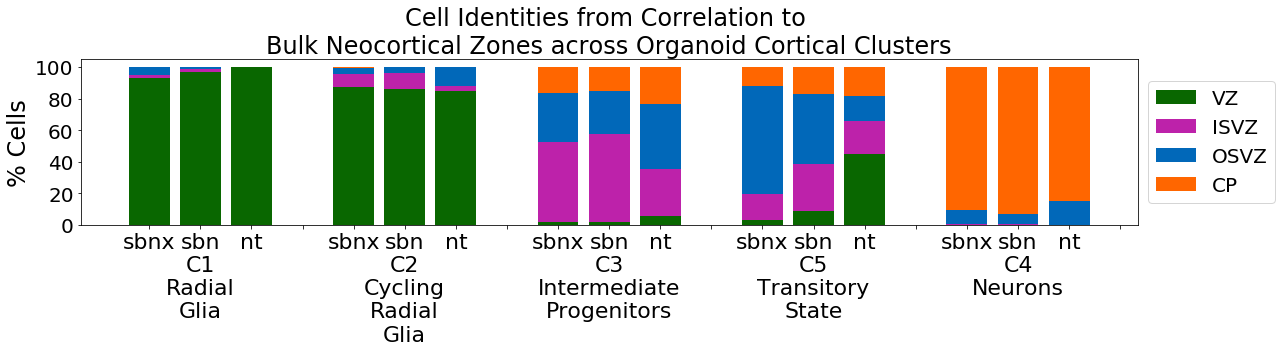

In [31]:
hutt_samps = ['VZ','ISVZ','OSVZ','CP']
hutt_samp_dict = {'VZ':'blue','ISVZ':'green','OSVZ':'orange','CP':'red'}
cortical_map = {1:'Radial Glia',7:'Cycling Radial Glia',5:'Transitory State',3:'Intermediate Progenitors',0:'Neurons'}
colorss=['blue','green','orange','red','gray']
colorss=[(9./255.,103./255,0),(189./255.,34./255,170/255.),(1./255.,104./255,185./255),(255./255.,102./255,0)]

plt.figure(figsize=(16,5))
ax=plt.subplot(111)

for jj,tx in enumerate(['sbnx','sbn','nt']):
    
    for k,clust in enumerate([1,7,3,5,0]):

        #ax = plt.subplot(int(str('51')+str(k+1)))
        corrs = {}
        for huttner_samp in hutt_samps:
            corrs[huttner_samp] = []
            for cell in clust_df_log_rpm[clust].columns:
                if (huttner_samp,cell) not in corr_maps_tx[tx]: continue
                corrs[huttner_samp].append(corr_maps_tx[tx][(huttner_samp,cell)])

        num_assign = {}
        for huttner_samp in hutt_samps:
            num_assign[huttner_samp] = 0
        #num_assign['unknown'] = 0

        for j in range(len(corrs['VZ'])):
            corr_list = [corrs[huttner_samp][j] for huttner_samp in hutt_samps]
            #if sorted(corr_list)[-1]/sorted(corr_list)[-2] < 1.05:
            #    num_assign['unknown'] += 1
            #else:
            num_assign[hutt_samps[np.argmax(corr_list)]] += 1

        #plt.bar(range(len(num_assign)),[num_assign[x] for x in num_assign],color=['blue','green','orange','red','gray'],linewidth=1,edgecolor='black')
        prev_y = 0
        sum_assign = float(sum(num_assign.values()))
        for j,x in enumerate(num_assign):
            if k==4 and tx == 'sbnx':
                plt.bar(4*k+jj,num_assign[x]/sum_assign,bottom=prev_y,color=colorss[j],label=hutt_samps[j])#,linewidth=1,edgecolor='black')
            else:
                plt.bar(4*k+jj,num_assign[x]/sum_assign,bottom=prev_y,color=colorss[j])
            prev_y += num_assign[x]/sum_assign
    
xtick_labs = []
for x in cort_clusts:
    xtick_labs.append('sbnx')
    xtick_labs.append('sbn\n'+'C'+str(clust_out_map[x[0]])+'\n'+x[1].replace(' ','\n').replace('-','-\n'))
    xtick_labs.append('nt')
    xtick_labs.append('')
    #xtick_labs.append('')
    #xtick_labs.append('C'+str(clust_out_map[x[0]])+'\n'+x[1].replace(' ','\n').replace('-','-\n'))
    #xtick_labs.append('')
    #xtick_labs.append('')
    
plt.xticks(range(len([1,7,3,5,0])*4),xtick_labs,fontsize=22)
plt.ylim(0,1.05)
plt.title('Cell Identities from Correlation to \nBulk Neocortical Zones across Organoid Cortical Clusters',fontsize=24)
plt.ylabel('% Cells',fontsize=24)
plt.yticks([0,0.2,0.4,0.6,0.8,1],[0,20,40,60,80,100],fontsize=20)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
lgd=ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=20)
plt.tight_layout()
plt.savefig('/mnt/e/MPIMG/Elkabetz/Mutukula_etal_Paper/Supplemental_Figures/Fig1/huttner_corr_1c_b.pdf',
            bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [ ]:
hutt_samps = ['VZ','ISVZ','OSVZ','CP']
hutt_samp_dict = {'VZ':'yellow','ISVZ':'orange','OSVZ':'red','CP':'purple'}
cortical_map = {1:'Radial Glia',7:'Cycling Radial Glia',5:'Transitory State',3:'Intermediate Progenitors',0:'Neurons'}
colorss=['blue','green','orange','red','gray']
colorss=[(9./255.,103./255,0),(189./255.,34./255,170/255.),(1./255.,104./255,185./255),(255./255.,102./255,0)]

plt.figure(figsize=(16,5))
ax=plt.subplot(111)

for jj,tx in enumerate(['sbnx','sbn','nt']):
    
    for k,clust in enumerate([1,7,3,5,0]):

        #ax = plt.subplot(int(str('51')+str(k+1)))
        corrs = {}
        for huttner_samp in hutt_samps:
            corrs[huttner_samp] = []
            for cell in clust_df_log_rpm[clust].columns:
                if (huttner_samp,cell) not in corr_maps_tx[tx]: continue
                corrs[huttner_samp].append(corr_maps_tx[tx][(huttner_samp,cell)])

        num_assign = {}
        for huttner_samp in hutt_samps:
            num_assign[huttner_samp] = 0
        #num_assign['unknown'] = 0

        for j in range(len(corrs['VZ'])):
            corr_list = [corrs[huttner_samp][j] for huttner_samp in hutt_samps]
            #if sorted(corr_list)[-1]/sorted(corr_list)[-2] < 1.05:
            #    num_assign['unknown'] += 1
            #else:
            num_assign[hutt_samps[np.argmax(corr_list)]] += 1

        #plt.bar(range(len(num_assign)),[num_assign[x] for x in num_assign],color=['blue','green','orange','red','gray'],linewidth=1,edgecolor='black')
        prev_y = 0
        sum_assign = float(sum(num_assign.values()))
        for j,x in enumerate(num_assign):
            if k==4 and tx == 'sbnx':
                plt.bar(4*k+jj,num_assign[x]/sum_assign,bottom=prev_y,color=colorss[j],label=hutt_samps[j])#,linewidth=1,edgecolor='black')
            else:
                plt.bar(4*k+jj,num_assign[x]/sum_assign,bottom=prev_y,color=colorss[j])
            prev_y += num_assign[x]/sum_assign
    
xtick_labs = []
for x in cort_clusts:
    xtick_labs.append('sbnx')
    xtick_labs.append('sbn\n'+'C'+str(clust_out_map[x[0]])+'\n'+x[1].replace(' ','\n').replace('-','-\n'))
    xtick_labs.append('nt')
    xtick_labs.append('')
    #xtick_labs.append('')
    #xtick_labs.append('C'+str(clust_out_map[x[0]])+'\n'+x[1].replace(' ','\n').replace('-','-\n'))
    #xtick_labs.append('')
    #xtick_labs.append('')
    
plt.xticks(range(len([1,7,3,5,0])*4),xtick_labs,fontsize=22)
plt.ylim(0,1.05)
plt.title('Cell Identities from Correlation to \nBulk Neocortical Zones across Organoid Cortical Clusters',fontsize=24)
plt.ylabel('% Cells',fontsize=24)
plt.yticks([0,0.2,0.4,0.6,0.8,1],[0,20,40,60,80,100],fontsize=20)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
lgd=ax.legend(loc='center left', bbox_to_anchor=(1, 0.5),fontsize=20)
plt.tight_layout()
#plt.savefig('/mnt/e/MPIMG/Elkabetz/Mutukula_etal_Paper/Supplemental_Figures/Fig1/huttner_corr_1c_b.pdf',
#            bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()